# Methoden en Technieken -- Blok 2

## Datapunt 2a,

In deze opdracht worden de volgende leeruitkomsten getoetst, relevante termen zijn **dik** gedrukt:
- A2: Je stelt voor een AI-oplossing juridische, ethische, organisatorische, **functionele en
technische requirements** op.
- B1: Je **verkent en prepareert een dataset voor het trainen en testen van een AI-model en
kan de voor- en nadelen van het gebruik van een bestaande dataset onderbouwen**, rekening
houdend met technische en ethische randvoorwaarden.
- B2: Je **stelt op basis van requirements en data een geschikte architectuur voor een AI-
oplossing op en selecteert daarvoor passende AI-technieken gebruik makend van bijvoorbeeld**
machine learning, **deep learning**, kennisrepresentatie, computer vision en **natural language
processing**.
- B3: Je **ontwikkelt een nieuw** of voorgetraind **AI-model volgens een iteratief en systematisch
proces**.
- C2: **Je evalueert en beoordeelt de kwaliteit van een AI-model aan de hand van kwaliteitscriteria die in het vakgebied erkend worden** zoals robustness, **performance**, scalability,
explainability, **model complexity** en resource demand.

Dit is een individuele opdracht. Het is toegestaan met elkaar de opdracht te bespreken, maar iedereen schrijft zijn eigen code en antwoorden. Mocht je code van het internet hebben overgenomen/aangepast, vermeld dan de bron in het commentaar. Het gebruik van generatieve AI (Chat-GPT, etc...) is *alleen* toegestaan bij de voorbereiding op de opdracht. Denk hierbj aan activiteiten zoals brainstormen, of het maken van een plan. Het is niet toegestaan code of tekst van generative AI over te nemen. (Level 2 van de AI Assessment Scale)



## De opdracht

In de slides van les 3 staat hoe een Engels - Nederlands vertaalmodel gemaakt wordt met een transformer-encoder en -decoder.

### Deel 1
#### Deel 1a
Maak dit model na en fit dit model.

In [176]:
# ik heb er kopjes bijgezet (zoals: # 1.1 Data Inladen) zo is het makkelijker om mijn code terug te vinden als ik ernaar refereer in mijn antwoord. 
# Ik heb de nederlandse dataset gedownload van https://www.manythings.org/anki/
# 95+% van de code komt van Deep Learning with Python 3rd. Edition Chapter 15 (er zijn minimale aanpassingen, als ze het waard zijn aan te kaarten doe ik dat)

# 1.1 Data Inladen
import pathlib
text_path = pathlib.Path("./dataset/nld-eng/nld.txt")

with open(text_path) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    parts = line.split("\t")
    english = parts[0]
    dutch = parts[1]
    dutch = "[start] " + dutch + " [end]"
    text_pairs.append((english, dutch))

# 1.2 Data Splitsen
import random
random.seed(42) # ik voeg een random seed toe. In deel 2 ga ik de code kopiëren en plakken en dan wil ik dezelfde resultaten behalen
random.shuffle(text_pairs)
val_samples = int(0.15 * len(text_pairs))
train_samples = len(text_pairs) - 2 * val_samples

train_pairs = text_pairs[:train_samples] # 70%
val_pairs = text_pairs[train_samples : train_samples + val_samples] # 15%
test_pairs = text_pairs[train_samples + val_samples :] # 15%

In [177]:
# 1.3.1 Sample Training Data ~ Chollet samplet data voor het splitsen wat in mijn ogen verkeerd is, aangezien de gesampelde data kan eindigen in je testset en zo dus data van je testset inziet!!!
for i in range(20):
    print(train_pairs[i])

('My sister was a beautiful woman.', '[start] Mijn zus was een erg knappe vrouw. [end]')
('We banished him from the country.', '[start] We hebben hem uit het land verbannen. [end]')
('Was the victim male or female?', '[start] Was het slachtoffer een man of een vrouw? [end]')
('I often tell jokes.', '[start] Ik vertel vaak moppen. [end]')
("I'm not sure about this.", '[start] Hier ben ik niet zeker van. [end]')
('I want you to be safe.', '[start] Ik wil dat je veilig bent. [end]')
("Tom's easily offended.", '[start] Tom is snel beledigd. [end]')
('She was born in America.', '[start] Ze is in Amerika geboren. [end]')
('Life is one big circus.', '[start] Het leven is één groot circus. [end]')
("We need to find out who he is and who he's working for.", '[start] We moeten te weten komen wie hij is en voor wie hij werkt. [end]')
("I don't know how to swim.", '[start] Ik kan niet zwemmen. [end]')
("Don't tell Tom.", '[start] Vertel het niet tegen Tom. [end]')
("We're having a barbecue.", '[st

In [178]:
# 1.3.2 Sample more Training Data (eigen inbreng)
# ik sorteer ik ze van klein naar groot zodat ik de kortste samples kan bekijken aangezien ik in het vorige blok alleen lange samples krijg
sorted_pairs = sorted(train_pairs, key=lambda p: len(p[0]) + len(p[1]))
for i in range(10):
    print(sorted_pairs[i])

# 1.3.3 Inspect data length
sentence_lengths = []
for x in range(len(sorted_pairs)):
    length = len(sorted_pairs[x][0].split())
    if length not in sentence_lengths:
        sentence_lengths.append(length)
print(f"Included Sentence Lengths: {sentence_lengths}")


('Hi.', '[start] Hoi. [end]')
('Who?', '[start] Wie? [end]')
('Run.', '[start] Ren! [end]')
('Run!', '[start] Ren! [end]')
('Go.', '[start] Lopen! [end]')
('Hello.', '[start] Hi! [end]')
('Hello!', '[start] Hoi. [end]')
('Stop!', '[start] Halt! [end]')
('Help!', '[start] Help! [end]')
('Hello.', '[start] Hoi. [end]')
Included Sentence Lengths: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 17, 19, 20, 21, 22, 24, 23, 28, 30]


In [179]:
# 1.4 Strip Punctuation
import tensorflow as tf
from keras import layers
import string
import re

strip_chars = string.punctuation # origineel werd ¿ hier ook weggehaald maar dit symbool komt niet voor in mijn dataset
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", ""
    )

vocab_size = 15000
sequence_length = 20

english_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
dutch_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_dutch_texts = [pair[1] for pair in train_pairs]
english_tokenizer.adapt(train_english_texts)
dutch_tokenizer.adapt(train_dutch_texts)

# 1.5 Check Vocabulary Size
print(f"English Vocabulary Size: {english_tokenizer.vocabulary_size()}")
print(f"Dutch Vocabulary Size: {dutch_tokenizer.vocabulary_size()}")


English Vocabulary Size: 9549
Dutch Vocabulary Size: 13473


In [180]:
# 1.6 Dataset Creëren 
batch_size = 64

def format_dataset(eng, spa):
    eng = english_tokenizer(eng)
    spa = dutch_tokenizer(spa)
    features = {"english": eng, "dutch": spa[:, :-1]}
    labels = spa[:, 1:]
    sample_weights = labels != 0
    return features, labels, sample_weights

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [181]:
# 1.7 Transformer Encoder
import numpy as np
import keras

class TransformerEncoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        # Self-attention layers
        self.self_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        # Feedforward layers
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, source, source_mask):
        # Self-attention computation
        residual = x = source
        mask = source_mask[:, None, :]
        x = self.self_attention(query=x, key=x, value=x, attention_mask=mask)
        x = x + residual
        x = self.self_attention_layernorm(x)
        # Feedforward computation
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x
    
# 1.8 Normalization
# Input shape: (batch_size, sequence_length, embedding_dim)
def layer_normalization(batch_of_sequences):
    # To compute mean and variance, we only pool data over the last
    # axis.
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)
    variance = np.var(batch_of_sequences, keepdims=True, axis=-1)
    return (batch_of_sequences - mean) / variance

# Input shape: (batch_size, height, width, channels)
def batch_normalization(batch_of_images):
    # Pools data over the batch axis (axis 0), which creates
    # interactions between samples in a batch
    mean = np.mean(batch_of_images, keepdims=True, axis=(0, 1, 2))
    variance = np.var(batch_of_images, keepdims=True, axis=(0, 1, 2))
    return (batch_of_images - mean) / variance

# 1.9 Transformer Decoder
class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        # Self-attention layers
        self.self_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        # Cross-attention layers
        self.cross_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.cross_attention_layernorm = layers.LayerNormalization()
        # Feedforward layers
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, target, source, source_mask):
        # Self-attention computation
        residual = x = target
        x = self.self_attention(query=x, key=x, value=x, use_causal_mask=True)
        x = x + residual
        x = self.self_attention_layernorm(x)
        # Cross-attention computation
        residual = x
        mask = source_mask[:, None, :]
        x = self.cross_attention(
            query=x, key=source, value=source, attention_mask=mask
        )
        x = x + residual
        x = self.cross_attention_layernorm(x)
        # Feedforward computation
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x
    
# 1.10 Seq-to-Seq Model with Transformer
hidden_dim = 256
intermediate_dim = 2048
num_heads = 8

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = layers.Embedding(vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(hidden_dim, intermediate_dim, num_heads)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="dutch") # not spanish
x = layers.Embedding(vocab_size, hidden_dim)(target)
x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer_1 = keras.Model([source, target], target_predictions)

# 1.11 Model Summary
transformer_1.summary()

2025-12-03 00:53:50.063381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, None, 256) │  3,840,000 │ english[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_26        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dutch (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,315,072 │ embedding_26[0][… │
│ (TransformerEncode… │                   │            │ not_equal_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_27        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, None, 256) │  3,840,000 │ dutch[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,578,752 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ not_equal_27[0][… │
│                     │                   │            │ embedding_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, None,      │  3,855,000 │ dropout_55[0][0]  │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,428,824 (55.04 MB)

 Trainable params: 14,428,824 (55.04 MB)

 Non-trainable params: 0 (0.00 B)

In [182]:
# 1.12 Train Model

transformer_1.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
history_1 = transformer_1.fit(train_ds, epochs=30, validation_data=val_ds) # training opslaan in history zodat we het kunnen plotten

Epoch 1/30
421/918 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.2591 - loss: 1.9041

2025-12-03 00:54:22.755610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 16 bytes spill stores, 16 bytes spill loads



918/918 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.4155 - loss: 1.3603 - val_accuracy: 0.5411 - val_loss: 0.9715
Epoch 2/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.5761 - loss: 0.8681 - val_accuracy: 0.6094 - val_loss: 0.7880
Epoch 3/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.6447 - loss: 0.6648 - val_accuracy: 0.6355 - val_loss: 0.7200
Epoch 4/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.6869 - loss: 0.5436 - val_accuracy: 0.6538 - val_loss: 0.6858
Epoch 5/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.7194 - loss: 0.4597 - val_accuracy: 0.6613 - val_loss: 0.6801
Epoch 6/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.7456 - loss: 0.3965 - val_accuracy: 0.6675 - val_loss: 0.6767
Epoch 7/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.7674 - loss: 0.3495 - val_accuracy: 0.6690 - val_loss: 0.6840
Epoch 8/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.7869 - loss: 0.3121 - val_accurac

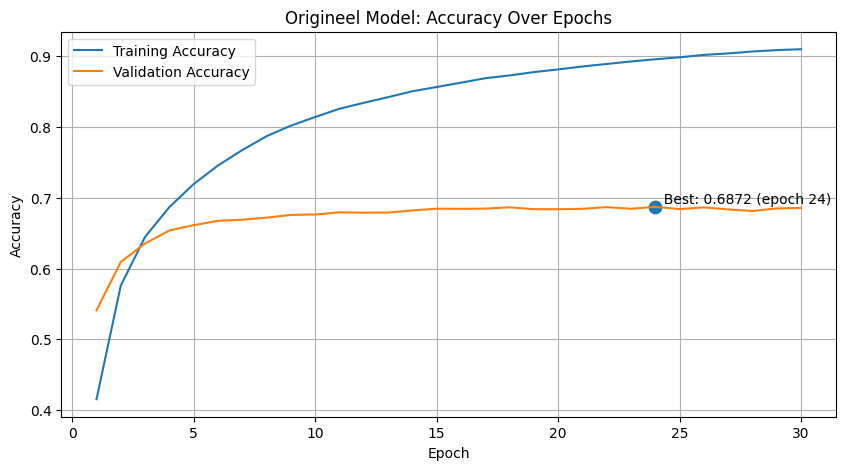

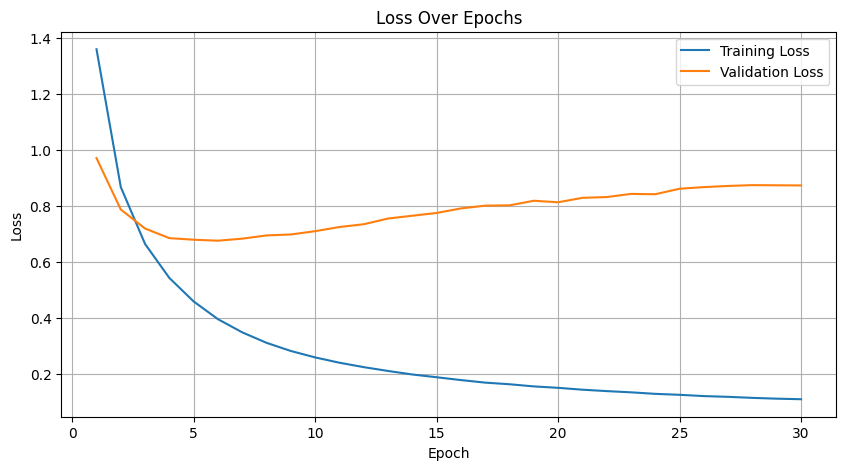

In [188]:
# 1.13 Plot Training and Validation

import matplotlib.pyplot as plt

# Extract values
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# markering hoogste val waarde
best_epoch = val_acc.index(max(val_acc)) + 1
best_val = max(val_acc)
plt.scatter(best_epoch, best_val, s=80)
plt.text(best_epoch, best_val,
         f"  Best: {best_val:.4f} (epoch {best_epoch})",
         verticalalignment='bottom')

plt.title('Origineel Model: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Plot loss (Werd niet getoond in de les)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Deel 1b
Bespreek de voor- en nadelen van de gebruikte dataset.

> Jouw antwoord hier
### Voordelen
- Diverse dataset, de dataset bevat woorden, zinnen van middelmatige lengte denk aan ongeveer 2 tot 15 woorden, en ook langere zinnen denk aan 16 tot 44 woorden. 

### Nadelen
- De dataset bevat de zelfde woorden met verschillende betekenissen (# 1.3.2). Zoals:
    - ('Hello.', '[start] Hi! [end]')
    - ('Hello!', '[start] Hoi. [end]')
    - ('Hello.', '[start] Hoi. [end]')

<br><br>In NLP kan dit een voordeel zijn, áls je de betekenissen van de woorden in acht neemt. Maar in het voorbeeld van de docent gebruiken we classificatie. Dat betekent dat dit het model juist in de war gaat brengen.
- De data is afkomstig van het Tatoeba project. Dat is een project waarbij mensen over de wereld zelf zinnen kunnen toevoegen, vertalen en verbteren. Dit betekent dat het dus ook fouten en onnauwkeurigheden kan bevatten. Ik heb zelf binnen 5 minuten een account aangemaakt en 2 zinnen vertaald. Dit geeft een indicatie van hoe makkelijk het is.

- Ik heb in #1.3.1 de data gesamplet en het viel me op dat er in de volgende zin een fout staat:
    - `('My family has house in the mountains.', '[start] Mijn familie heeft een huis in de bergen. [end]')` ~ De engelse zin is incorrect, het moet zijn `My family has a house in the mountains.`.
<br><br>Dit is één kleine fout in de 20 samples die ik heb bekeken. De volledige dataset bevat 83,864 samples. Statistisch gezien zouden er dan veel meer foutjes in moeten zitten.

- In de zin: `('Boil for ten minutes, stirring all the time.', '[start] Kook tien minuten en roer constant. [end]')` komen de betekenissen overeen, maar de exacte zinnen niet. In de gegeven code van de docent gebruiken we classificatie en accuracy. In een sample zoals dit blijkt het waarom dat geen slimme keus is. Als `'Boil for ten minutes, stirring all the time.'` vertaald zou worden naar `"[start] Kook tien minuten en blijf de hele tijd roeren [end]"` of `"[start] Kook voor tien minuten en blijf roeren [end]"` dan klopt de zin taalkundig, maar volgens het model niet. Dit is voornamelijk een nadeel van de technische keuzes van de docent, maar dit kun je ook zien als een nadeel van de dataset, aangezien de dataset dus samples bevat waarin zinnen niet **precies** vertaald zijn maar zó vertaald zijn dat ze de zelfde of ongeveer de zelfde betekenis hebben. 

- De tokenizers zijn niet vol genoeg. De nederlandse tokenizer bevat 13482 tokens en de Engelse bevat 9481 tokens. In Deep Learning with Python 3rd. Edition zegt Chollet in hoofdstuk 14: "We will build a vocabulary of 20,000 words, a good starting place for text classification problems.", maar de tokenizers halen beide niet de 15,000 laat staan 20,000. Dit geeft een indicatie dat er momenteel te weinig tokens zijn en dus te weinig data.


### Deel 2
We willen dit model nu verbeteren. Bedenk een (mogelijke) verbetering. Het is niet de bedoeling dat je bestaande pretrained modellen gebruikt. Train alles zelf.

#### Deel 2a
Stel een korte lijst van eisen op waar jouw verbeterde model aan hoort te voldoen. 

> Jouw antwoord hier
### Functionele Requirements
- Een hogere validatie accuraatheid behalen dan 0.6872... (zie #1.13)

### Technische Requirements
- model vanaf het begin zelf trainen (geen pretrained modellen gebruiken)

### Non-Functionele Requirement
- Ik moet woensdag alles inleveren dus dan moet alles klaar zijn

#### Deel 2b
Licht het volgende toe:
- Welke verbetering je uitvoert en waarom je denkt dat dit voor een verbetering zal zorgen.
- Welke maat je gebruikt om de verbetering te meten, en waarom.

Houd je antwoorden kort en bondig.

> Jouw antwoord hier
## Maatstaf
- Een extreem voordehand liggende verbetering is het gebruik van een andere maatstaf denk aan een maatstaf die betekenissen in acht neemt. Ik heb in de nadelen van de dataset besproken waarom dat een goede oplossing zou zijn. Maar dat is te simpel, lijkt me geen uitdaging, saai en flauw, aangezien het dan een beetje voelt alsof ik de opdracht aan het veranderen ben.
- Ik ga verder met het gebruik van classificatie en accuracy, omdat de gegeven code van de docent het model op deze manier beoordeelt. En omdat het mij een leuke uitdaging lijkt om een, in mijn ogen, "verkeerde of niet optimale" metric te gebruiken en daarop een goede score te halen. "However, in practice, next-token accuracy isn’t a great metric for machine translation models" (Chollet, 2025, Chapter 15, DLP 3rd. Edition)

## Verbetering
Ik heb aangegeven dat Chollet zegt in DLP dat een vocabulary van 20,000 een goed start punt is voor de meeste text classificatie problemen. Maar de huidige vocabularies bevatten voor nederlands 13477 en voor engels 9536 woorden. Dit probleem kunnen we oplossen door meer data toe te voegen, maar dit kan het probleem introduceren dat de nieuwe data verschilt van de originele data. Hierdoor **kan** het voor het model moeilijker worden om te trainen. En predicten op de testset kan ook moeilijker worden aangezien de testset enkel data van de oorspronkelijke dataset bevat. 

Een alternatief is om gebruik te maken van n-grams. Met gebruik van n-grams kunnen we proberen de vocabulary aan te vullen zodat we een vocabulary van 20,000 behalen. Ik denk dat dit het model zal verbeteren omdat we het advies opvolgen van Chollet door de vocabulary aan te vullen tot aan 20,000.

#### Deel 2c
Train dit verbeterde model.

# 2.1. Bigrams

In [137]:
# Copy Paste van hierboven
# Aanpassingen:
# - Bigrams i.p.v. Unigrams
# - Vocabulary size van 15,000 naar 20,000

# 2.1.1 Data Inladen
import pathlib
text_path = pathlib.Path("./dataset/nld-eng/nld.txt")

with open(text_path) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    parts = line.split("\t")
    english = parts[0]
    dutch = parts[1]
    dutch = "[start] " + dutch + " [end]"
    text_pairs.append((english, dutch))

# 2.1.2 Data Splitsen
import random
random.seed(42) # dezelfde random seed
random.shuffle(text_pairs)
val_samples = int(0.15 * len(text_pairs))
train_samples = len(text_pairs) - 2 * val_samples

train_pairs = text_pairs[:train_samples] # 70%
val_pairs = text_pairs[train_samples : train_samples + val_samples] # 15%
test_pairs = text_pairs[train_samples + val_samples :] # 15%

In [138]:
# 2.1.4 Strip Punctuation
import tensorflow as tf
from keras import layers
import string
import re

strip_chars = string.punctuation # origineel werd ¿ hier ook weggehaald maar dit symbool komt niet voor in mijn dataset
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", ""
    )

vocab_size = 20000 # vocabulary van 15000 naar 20000 veranderd
sequence_length = 20

english_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    ngrams=2
)
dutch_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
    ngrams=2
)
train_english_texts = [pair[0] for pair in train_pairs]
train_dutch_texts = [pair[1] for pair in train_pairs]
english_tokenizer.adapt(train_english_texts)
dutch_tokenizer.adapt(train_dutch_texts)


In [139]:
# 2.1.5.1 Check Vocabulary Size
print(f"English Vocabulary Size: {english_tokenizer.vocabulary_size()}")
print(f"Dutch Vocabulary Size: {dutch_tokenizer.vocabulary_size()}")

English Vocabulary Size: 20000
Dutch Vocabulary Size: 20000


In [140]:
# 2.1.5.2 Check English Vocabulary
print("First 10")
tokens_en = english_tokenizer.get_vocabulary()[:10]
for i, x in enumerate(tokens_en):
    print(i, x)
print()
print("Last 10")
tokens_en = english_tokenizer.get_vocabulary()[-10:]
for i, x in enumerate(tokens_en):
    print(i+19990, x)

First 10
0 
1 [UNK]
2 i
3 tom
4 the
5 you
6 to
7 a
8 is
9 that

Last 10
19990 greedy person
19991 great if
19992 great idea
19993 gravity
19994 grass is
19995 grandmother was
19996 grandmother every
19997 grandfather gave
19998 graham greene
19999 graham


In [141]:
# 2.1.5.3 Check Dutch Vocabulary

print("First 10")
tokens_nl = dutch_tokenizer.get_vocabulary()[:10]
for i, x in enumerate(tokens_nl):
    print(i, x)
print()
print("Last 10")
tokens_nl = dutch_tokenizer.get_vocabulary()[-10:]
for i, x in enumerate(tokens_nl):
    print(i+19990, x)

First 10
0 
1 [UNK]
2 [start]
3 [end]
4 ik
5 [start] ik
6 tom
7 is
8 het
9 je

Last 10
19990 vijf [end]
19991 vijand niet
19992 vieze
19993 vier keer
19994 viel wel
19995 viel tom
19996 viel tegen
19997 viel het
19998 viel een
19999 viel bijna


In [142]:
# 2.1.6 Dataset Creëren 
batch_size = 64
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [143]:
# 2.1.7 Transformer Encoder
import numpy as np
import keras
# class defined above
    
# 2.1.8 Normalization
# functions defined above

# 2.1.9 Transformer Decoder
# class defined above
    
# 2.1.10 Seq-to-Seq Model with Transformer
hidden_dim = 256
intermediate_dim = 2048
num_heads = 8

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = layers.Embedding(vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(hidden_dim, intermediate_dim, num_heads)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="dutch") # not spanish
x = layers.Embedding(vocab_size, hidden_dim)(target)
x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer_2 = keras.Model([source, target], target_predictions)

# 2.1.11 Model Summary
transformer_2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, None, 256) │  5,120,000 │ english[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_20        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dutch (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,315,072 │ embedding_20[0][… │
│ (TransformerEncode… │                   │            │ not_equal_20[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_21        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, None, 256) │  5,120,000 │ dutch[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,578,752 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ not_equal_21[0][… │
│                     │                   │            │ embedding_21[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, None,      │  5,140,000 │ dropout_43[0][0]  │
│                     │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,273,824 (69.71 MB)

 Trainable params: 18,273,824 (69.71 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
# 2.1.12 Train Model

transformer_2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
history_2 = transformer_2.fit(train_ds, epochs=30, validation_data=val_ds) # training opslaan in history zodat we het kunnen plotten

Epoch 1/30
842/918 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3113 - loss: 3.6990

2025-12-02 23:16:51.722545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 16 bytes spill stores, 16 bytes spill loads



918/918 ━━━━━━━━━━━━━━━━━━━━ 60s 53ms/step - accuracy: 0.4039 - loss: 2.9910 - val_accuracy: 0.5432 - val_loss: 1.9096
Epoch 2/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5745 - loss: 1.7421 - val_accuracy: 0.6382 - val_loss: 1.3339
Epoch 3/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.6600 - loss: 1.2066 - val_accuracy: 0.6782 - val_loss: 1.1163
Epoch 4/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7174 - loss: 0.9149 - val_accuracy: 0.6964 - val_loss: 1.0411
Epoch 5/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7567 - loss: 0.7414 - val_accuracy: 0.7100 - val_loss: 1.0063
Epoch 6/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.7867 - loss: 0.6216 - val_accuracy: 0.7124 - val_loss: 1.0321
Epoch 7/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.8096 - loss: 0.5372 - val_accuracy: 0.7183 - val_loss: 1.0509
Epoch 8/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.8275 - loss: 0.4740 - val_accurac

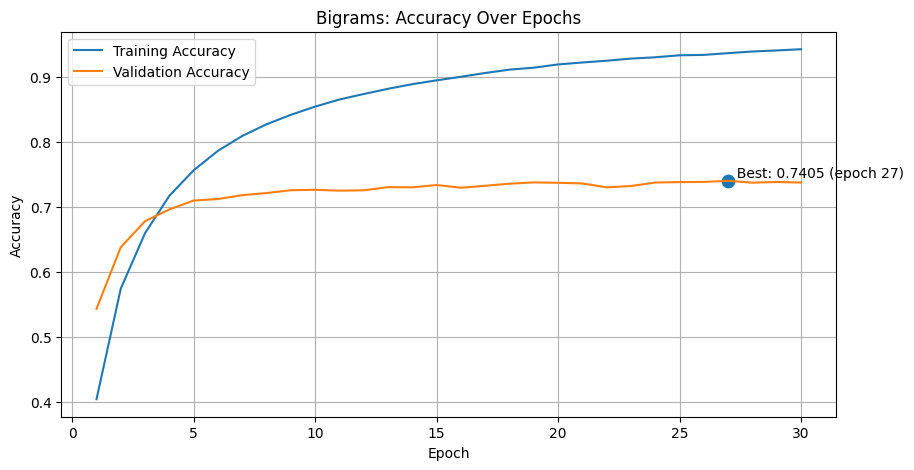

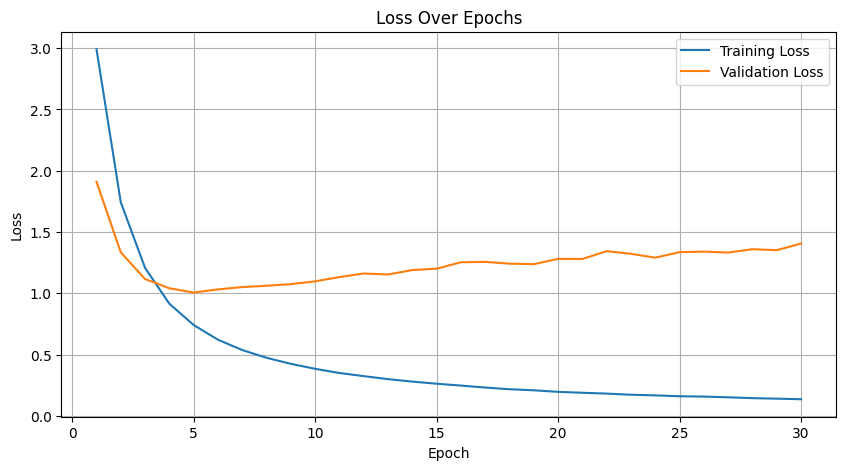

In [145]:
# 2.1.13 Plot Training and Validation

import matplotlib.pyplot as plt

# Extract values
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# markering hoogste val waarde
best_epoch = val_acc.index(max(val_acc)) + 1
best_val = max(val_acc)
plt.scatter(best_epoch, best_val, s=80)
plt.text(best_epoch, best_val,
         f"  Best: {best_val:.4f} (epoch {best_epoch})",
         verticalalignment='bottom')

plt.title('Bigrams: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Plot loss (Werd niet getoond in de les)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# 2.2. Trigrams

In [146]:
# Copy Paste van hierboven
# Aanpassingen:
# - Trigrams i.p.v. Bigrams
# - Vocabulary size nog steeds 20,000

# 2.2.1 Data Inladen
import pathlib
text_path = pathlib.Path("./dataset/nld-eng/nld.txt")

with open(text_path) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    parts = line.split("\t")
    english = parts[0]
    dutch = parts[1]
    dutch = "[start] " + dutch + " [end]"
    text_pairs.append((english, dutch))

# 2.2.2 Data Splitsen
import random
random.seed(42) # dezelfde random seed
random.shuffle(text_pairs)
val_samples = int(0.15 * len(text_pairs))
train_samples = len(text_pairs) - 2 * val_samples

train_pairs = text_pairs[:train_samples] # 70%
val_pairs = text_pairs[train_samples : train_samples + val_samples] # 15%
test_pairs = text_pairs[train_samples + val_samples :] # 15%

In [147]:
# 2.2.4 Strip Punctuation
import tensorflow as tf
from keras import layers
import string
import re

strip_chars = string.punctuation # origineel werd ¿ hier ook weggehaald maar dit symbool komt niet voor in mijn dataset
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", ""
    )

vocab_size = 20000 # vocabulary van 15000 naar 20000 veranderd
sequence_length = 20

english_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    ngrams=3
)
dutch_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
    ngrams=3
)
train_english_texts = [pair[0] for pair in train_pairs]
train_dutch_texts = [pair[1] for pair in train_pairs]
english_tokenizer.adapt(train_english_texts)
dutch_tokenizer.adapt(train_dutch_texts)


In [148]:
# 2.2.5.1 Check Vocabulary Size
print(f"English Vocabulary Size: {english_tokenizer.vocabulary_size()}")
print(f"Dutch Vocabulary Size: {dutch_tokenizer.vocabulary_size()}")

English Vocabulary Size: 20000
Dutch Vocabulary Size: 20000


In [149]:
# 2.2.5.2 Check English Vocabulary
print("First 10")
tokens_en = english_tokenizer.get_vocabulary()[:10]
for i, x in enumerate(tokens_en):
    print(i, x)
print()
print("Last 10")
tokens_en = english_tokenizer.get_vocabulary()[-10:]
for i, x in enumerate(tokens_en):
    print(i+19990, x)

First 10
0 
1 [UNK]
2 i
3 tom
4 the
5 you
6 to
7 a
8 is
9 that

Last 10
19990 the scissors
19991 the scenery
19992 the same bus
19993 the same as
19994 the salt
19995 the rules of
19996 the room is
19997 the roads are
19998 the roads
19999 the risk


In [150]:
# 2.2.5.3 Check Dutch Vocabulary

print("First 10")
tokens_nl = dutch_tokenizer.get_vocabulary()[:10]
for i, x in enumerate(tokens_nl):
    print(i, x)
print()
print("Last 10")
tokens_nl = dutch_tokenizer.get_vocabulary()[-10:]
for i, x in enumerate(tokens_nl):
    print(i+19990, x)

First 10
0 
1 [UNK]
2 [start]
3 [end]
4 ik
5 [start] ik
6 tom
7 is
8 het
9 je

Last 10
19990 stond op om
19991 stond [end]
19992 stofzuigen [end]
19993 stofzuigen
19994 stikstof [end]
19995 stijgt [end]
19996 stijgen [end]
19997 stijgen
19998 stierf in de
19999 stierf [end]


In [151]:
# 2.2.6 Dataset Creëren 
batch_size = 64
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [152]:
# 2.2.7 Transformer Encoder
import numpy as np
import keras
# class defined above
    
# 2.2.8 Normalization
# functions defined above

# 2.2.9 Transformer Decoder
# class defined above
    
# 2.2.10 Seq-to-Seq Model with Transformer
hidden_dim = 256
intermediate_dim = 2048
num_heads = 8

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = layers.Embedding(vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(hidden_dim, intermediate_dim, num_heads)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="dutch") # not spanish
x = layers.Embedding(vocab_size, hidden_dim)(target)
x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer_3 = keras.Model([source, target], target_predictions)

# 1.11 Model Summary
transformer_3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, None, 256) │  5,120,000 │ english[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_22        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dutch (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,315,072 │ embedding_22[0][… │
│ (TransformerEncode… │                   │            │ not_equal_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_23        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, None, 256) │  5,120,000 │ dutch[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,578,752 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ not_equal_23[0][… │
│                     │                   │            │ embedding_23[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, None,      │  5,140,000 │ dropout_47[0][0]  │
│                     │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,273,824 (69.71 MB)

 Trainable params: 18,273,824 (69.71 MB)

 Non-trainable params: 0 (0.00 B)

In [153]:
# 2.2.12 Train Model

transformer_3.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
history_3 = transformer_3.fit(train_ds, epochs=30, validation_data=val_ds) # training opslaan in history zodat we het kunnen plotten

Epoch 1/30
 30/918 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.2365 - loss: 6.9811

2025-12-02 23:37:59.896629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 16 bytes spill stores, 16 bytes spill loads



918/918 ━━━━━━━━━━━━━━━━━━━━ 60s 53ms/step - accuracy: 0.4536 - loss: 3.4972 - val_accuracy: 0.5752 - val_loss: 2.2562
Epoch 2/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.6017 - loss: 2.0562 - val_accuracy: 0.6678 - val_loss: 1.5453
Epoch 3/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.6795 - loss: 1.4505 - val_accuracy: 0.7136 - val_loss: 1.2416
Epoch 4/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7303 - loss: 1.1168 - val_accuracy: 0.7364 - val_loss: 1.0955
Epoch 5/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7655 - loss: 0.9159 - val_accuracy: 0.7487 - val_loss: 1.0368
Epoch 6/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7910 - loss: 0.7830 - val_accuracy: 0.7606 - val_loss: 1.0192
Epoch 7/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.8109 - loss: 0.6861 - val_accuracy: 0.7628 - val_loss: 1.0447
Epoch 8/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.8273 - loss: 0.6116 - val_accurac

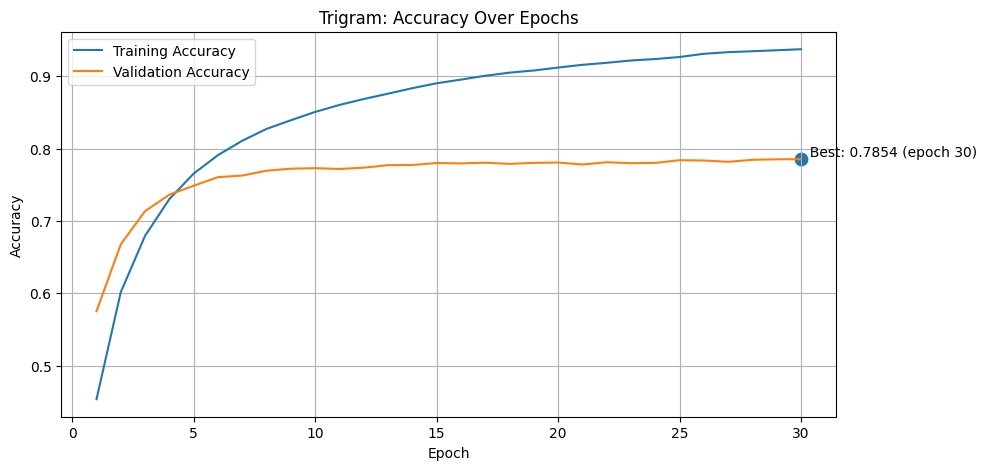

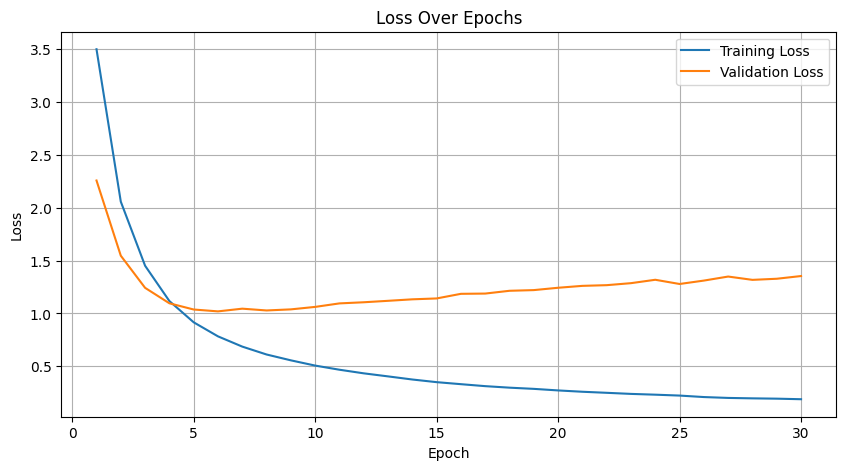

In [154]:
# 2.2.13 Plot Training and Validation

import matplotlib.pyplot as plt

# Extract values
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# markering hoogste val waarde
best_epoch = val_acc.index(max(val_acc)) + 1
best_val = max(val_acc)
plt.scatter(best_epoch, best_val, s=80)
plt.text(best_epoch, best_val,
         f"  Best: {best_val:.4f} (epoch {best_epoch})",
         verticalalignment='bottom')

plt.title('Trigram: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Plot loss (Werd niet getoond in de les)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# 2.3. N-Grams, N=4

In [155]:
# Copy Paste van hierboven
# Aanpassingen:
# - Trigrams i.p.v. Bigrams
# - Vocabulary size nog steeds 20,000

# 2.3.1 Data Inladen
import pathlib
text_path = pathlib.Path("./dataset/nld-eng/nld.txt")

with open(text_path) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    parts = line.split("\t")
    english = parts[0]
    dutch = parts[1]
    dutch = "[start] " + dutch + " [end]"
    text_pairs.append((english, dutch))

# 2.3.2 Data Splitsen
import random
random.seed(42) # dezelfde random seed
random.shuffle(text_pairs)
val_samples = int(0.15 * len(text_pairs))
train_samples = len(text_pairs) - 2 * val_samples

train_pairs = text_pairs[:train_samples] # 70%
val_pairs = text_pairs[train_samples : train_samples + val_samples] # 15%
test_pairs = text_pairs[train_samples + val_samples :] # 15%

In [156]:
# 2.3.4 Strip Punctuation
import tensorflow as tf
from keras import layers
import string
import re

strip_chars = string.punctuation # origineel werd ¿ hier ook weggehaald maar dit symbool komt niet voor in mijn dataset
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", ""
    )

vocab_size = 20000 # vocabulary van 15000 naar 20000 veranderd
sequence_length = 20

english_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    ngrams=4
)
dutch_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
    ngrams=4
)
train_english_texts = [pair[0] for pair in train_pairs]
train_dutch_texts = [pair[1] for pair in train_pairs]
english_tokenizer.adapt(train_english_texts)
dutch_tokenizer.adapt(train_dutch_texts)


In [157]:
# 2.3.5.1 Check Vocabulary Size
print(f"English Vocabulary Size: {english_tokenizer.vocabulary_size()}")
print(f"Dutch Vocabulary Size: {dutch_tokenizer.vocabulary_size()}")

English Vocabulary Size: 20000
Dutch Vocabulary Size: 20000


In [158]:
# 2.3.5.2 Check English Vocabulary
print("First 10")
tokens_en = english_tokenizer.get_vocabulary()[:10]
for i, x in enumerate(tokens_en):
    print(i, x)
print()
print("Last 10")
tokens_en = english_tokenizer.get_vocabulary()[-10:]
for i, x in enumerate(tokens_en):
    print(i+19990, x)

First 10
0 
1 [UNK]
2 i
3 tom
4 the
5 you
6 to
7 a
8 is
9 that

Last 10
19990 base
19991 bartender
19992 bars
19993 barked
19994 barbecue
19995 bar
19996 band
19997 balls
19998 ball with
19999 balcony


In [159]:
# 2.3.5.3 Check Dutch Vocabulary

print("First 10")
tokens_nl = dutch_tokenizer.get_vocabulary()[:10]
for i, x in enumerate(tokens_nl):
    print(i, x)
print()
print("Last 10")
tokens_nl = dutch_tokenizer.get_vocabulary()[-10:]
for i, x in enumerate(tokens_nl):
    print(i+19990, x)

First 10
0 
1 [UNK]
2 [start]
3 [end]
4 ik
5 [start] ik
6 tom
7 is
8 het
9 je

Last 10
19990 het ijs is
19991 het huis waarin
19992 het horloge
19993 het helpen [end]
19994 het hele jaar
19995 het gevonden
19996 het geen
19997 het feestje is
19998 het feest was
19999 het examen [end]


In [160]:
# 2.3.6 Dataset Creëren 
batch_size = 64
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [161]:
# 2.3.7 Transformer Encoder
import numpy as np
import keras
# class defined above
    
# 2.3.8 Normalization
# functions defined above

# 2.3.9 Transformer Decoder
# class defined above
    
# 2.3.10 Seq-to-Seq Model with Transformer
hidden_dim = 256
intermediate_dim = 2048
num_heads = 8

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = layers.Embedding(vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(hidden_dim, intermediate_dim, num_heads)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="dutch") # not spanish
x = layers.Embedding(vocab_size, hidden_dim)(target)
x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer_4 = keras.Model([source, target], target_predictions)

# 2.3.11 Model Summary
transformer_4.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, None, 256) │  5,120,000 │ english[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_24        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dutch (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,315,072 │ embedding_24[0][… │
│ (TransformerEncode… │                   │            │ not_equal_24[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_25        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, None, 256) │  5,120,000 │ dutch[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,578,752 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ not_equal_25[0][… │
│                     │                   │            │ embedding_25[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, None,      │  5,140,000 │ dropout_51[0][0]  │
│                     │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,273,824 (69.71 MB)

 Trainable params: 18,273,824 (69.71 MB)

 Non-trainable params: 0 (0.00 B)

In [162]:
# 2.3.12 Train Model

transformer_4.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
history_4 = transformer_4.fit(train_ds, epochs=30, validation_data=val_ds) # training opslaan in history zodat we het kunnen plotten

Epoch 1/30
421/918 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.3862 - loss: 4.9384

2025-12-03 00:00:28.235044: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 16 bytes spill stores, 16 bytes spill loads



918/918 ━━━━━━━━━━━━━━━━━━━━ 60s 53ms/step - accuracy: 0.4946 - loss: 3.5074 - val_accuracy: 0.6117 - val_loss: 2.2208
Epoch 2/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.6370 - loss: 2.0119 - val_accuracy: 0.6974 - val_loss: 1.4875
Epoch 3/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7080 - loss: 1.4054 - val_accuracy: 0.7370 - val_loss: 1.2081
Epoch 4/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7544 - loss: 1.0807 - val_accuracy: 0.7585 - val_loss: 1.0798
Epoch 5/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7853 - loss: 0.8900 - val_accuracy: 0.7672 - val_loss: 1.0607
Epoch 6/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.8086 - loss: 0.7609 - val_accuracy: 0.7761 - val_loss: 1.0356
Epoch 7/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.8260 - loss: 0.6696 - val_accuracy: 0.7737 - val_loss: 1.0543
Epoch 8/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.8401 - loss: 0.5991 - val_accurac

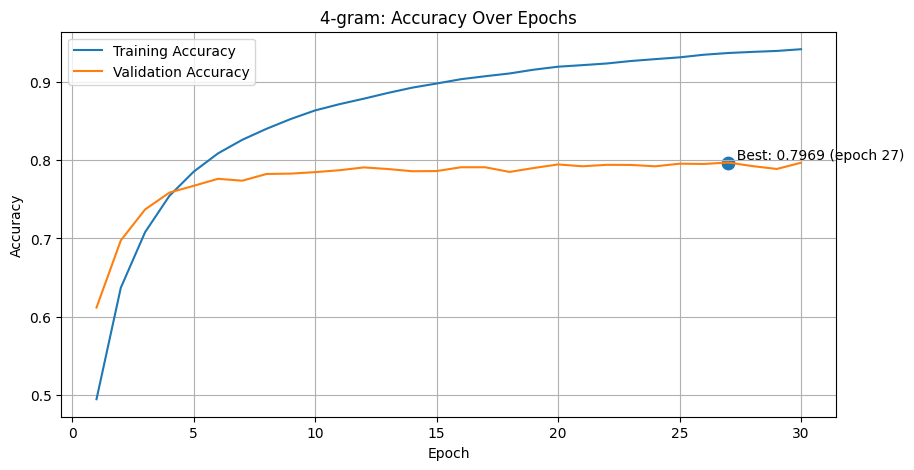

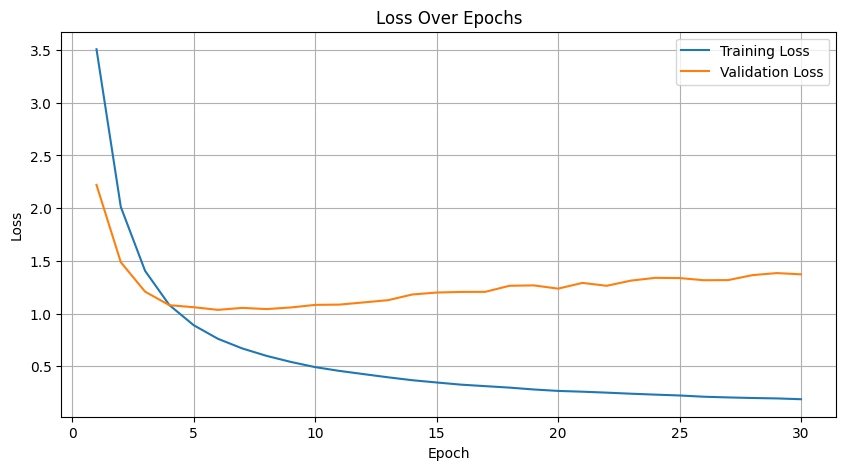

In [163]:
# 2.3.13 Plot Training and Validation

import matplotlib.pyplot as plt

# Extract values
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# markering hoogste val waarde
best_epoch = val_acc.index(max(val_acc)) + 1
best_val = max(val_acc)
plt.scatter(best_epoch, best_val, s=80)
plt.text(best_epoch, best_val,
         f"  Best: {best_val:.4f} (epoch {best_epoch})",
         verticalalignment='bottom')

plt.title('4-gram: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Plot loss (Werd niet getoond in de les)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Deel 3
#### Deel 3a
Evalueer het model.

# Evaluatie Training
Okéé, hierboven is het een beetje een chaos dus even concreet.

Ik heb 3 modellen getraind. Een Bigram model, Trigram model en een N=4-gram model. Hier de validatie accuracy van de modellen:
- Origineel val: 0.6871...
- Bigram val: 0.7405...
- trigram val: 0.7854...
- 4-gram val: 0.7969...

Er is een duidelijke trend te zien in de resultaten. Hoe hoger de N, hoe hoger de validation accuracy. Ook heb ik alle modellen samen geplot voor een duidelijker overzicht. Merkwaardig is dat de Trigram en 4-gram modellen hun beste resultaten behaalde op de laatste epoch, dit kan betekenen dat het model nog betere resultaten kon behalen met meer epochs. Ook als we naar de losses kijken van deze 2 modellen zien we dat de loss nog lichtjes aan het dalen was wat ook kan aangeven dat het model iets beter zou presteren met meer epochs.

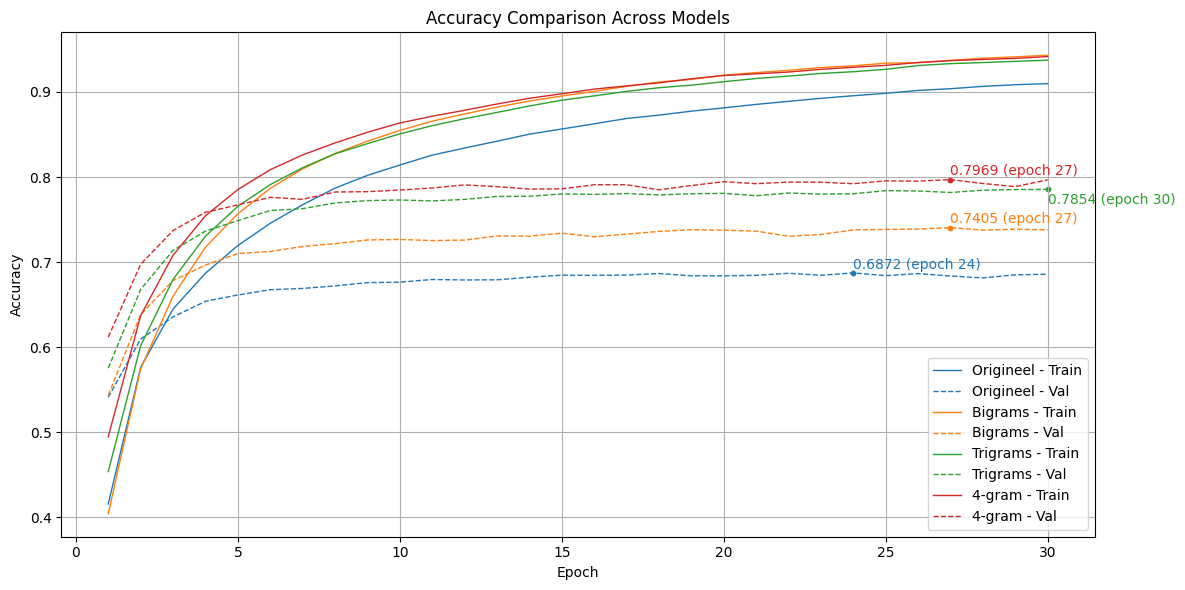

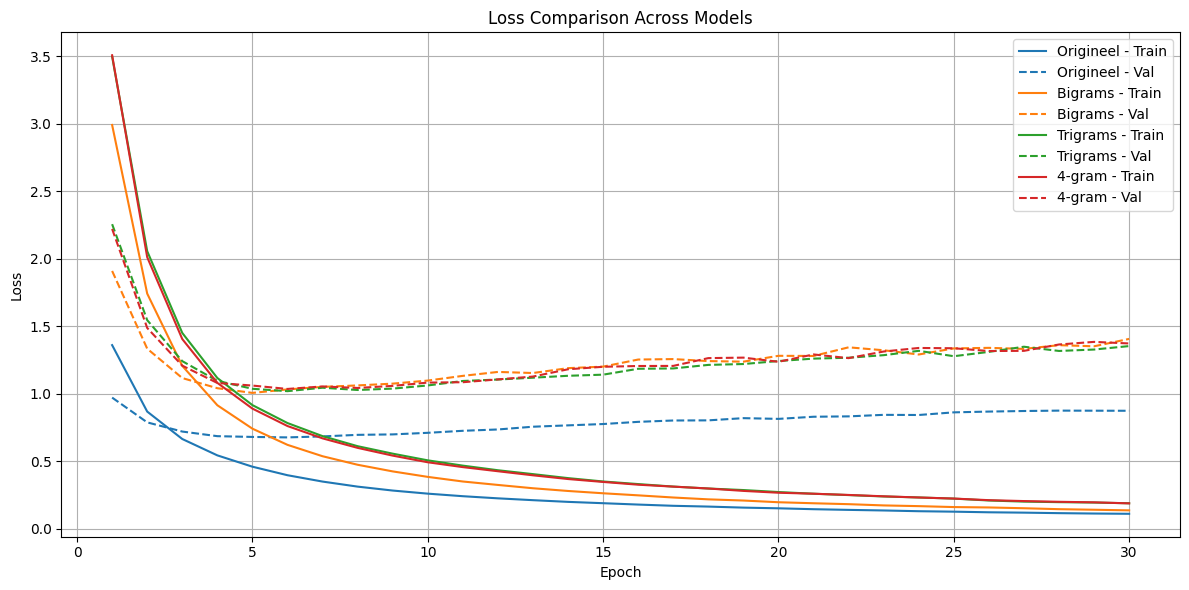

In [184]:
# 3.1
import matplotlib.pyplot as plt

histories = {
    "Origineel": history_1,
    "Bigrams": history_2,
    "Trigrams": history_3,
    "4-gram": history_4
}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# ---- ACCURACY ----
plt.figure(figsize=(12, 6))

x = 0
for (name, hist), color in zip(histories.items(), colors):
    epochs = range(1, len(hist.history['accuracy']) + 1)

    train_acc = hist.history["accuracy"]
    val_acc = hist.history["val_accuracy"]

    # Train
    plt.plot(epochs, train_acc, label=f"{name} - Train",
             color=color, linewidth=1)

    # Val
    plt.plot(epochs, val_acc, label=f"{name} - Val",
             color=color, linestyle="--", linewidth=1)

    # Mark highest validation accuracy
    best_epoch = val_acc.index(max(val_acc)) + 1
    best_val = max(val_acc)

    plt.scatter(best_epoch, best_val, color=color, s=10)

    # ervoor zorgen dat de trigram marker niet overlapt met 4-gram marker
    if x==2:
        plt.text(best_epoch, best_val - 0.017,
                f"{best_val:.4f} (epoch {best_epoch})",
                color=color,
                fontsize=10)
    else:
        plt.text(best_epoch, best_val + 0.005,
                f"{best_val:.4f} (epoch {best_epoch})",
                color=color,
                fontsize=10)
    x+=1


plt.title("Accuracy Comparison Across Models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ---- LOSS ----
plt.figure(figsize=(12, 6))

for (name, hist), color in zip(histories.items(), colors):
    epochs = range(1, len(hist.history['loss']) + 1)

    train_loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    plt.plot(epochs, train_loss, label=f"{name} - Train", color=color)
    plt.plot(epochs, val_loss, label=f"{name} - Val",
             color=color, linestyle="--")

plt.title("Loss Comparison Across Models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Evaluatie Testset
Bij het testen op de testset zien we dezelfde trend die we eerder observeerde. hoe hoger de N, hoe hoger de accuracy. Hier de resultaten (zie #3.3):
- Origineel: 0.0200... (???)
- Bigrams: 0.2875...
- Trigrams: 0.4394...
- 4-Grams: 0.7973... 

In codeblock #3.4 plot ik de train, val en test accuracy per model. De validatie accuracy stijgt langzaam met de toename van N in tegendeel tot de testset waarbij de accuracy omhoog schiet met elke N. Het verbaast me hoe goed het 4-gram model scoort op de testset. Ik had verwacht dat het goed zou scoren maar het scoort bijna precies even goed als de validatie set, beter zelfs, wat echt verassend goed is.

In [ ]:
# 3.2 Create test set
test_ds = make_dataset(test_pairs)

In [ ]:
# 3.3 Evaluate all models
test_results = {}

models = {
    "Origineel": transformer_1,
    "Bigrams": transformer_2,
    "Trigrams": transformer_3,
    "4-gram": transformer_4
}

for name, model in models.items():
    print(f"\n---- Evaluating {name} ----")
    loss, acc = model.evaluate(test_ds, verbose=0)
    test_results[name] = (loss, acc)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f}")



---- Evaluating Origineel ----
Test Loss: nan
Test Accuracy: 0.0200

---- Evaluating Bigrams ----
Test Loss: 10.7866
Test Accuracy: 0.2875

---- Evaluating Trigrams ----
Test Loss: 8.8406
Test Accuracy: 0.4394

---- Evaluating 4-gram ----
Test Loss: 1.3706
Test Accuracy: 0.7973


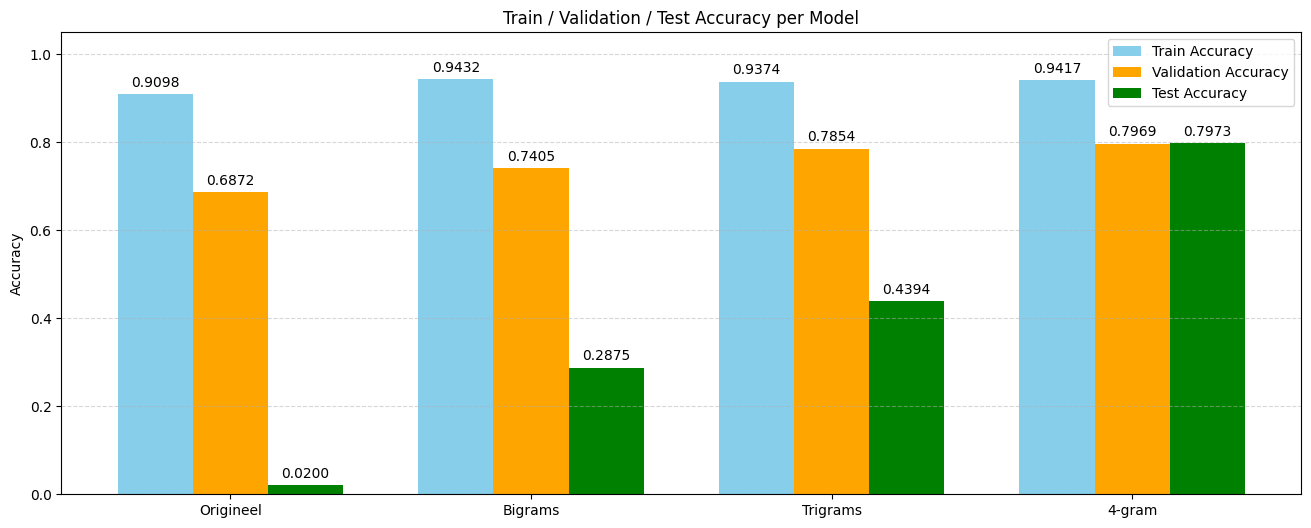

In [ ]:
# 3.4 Model Comparison
import matplotlib.pyplot as plt
import numpy as np

models = ["Origineel", "Bigrams", "Trigrams", "4-gram"]
histories = [history_1, history_2, history_3, history_4]

# Collect accuracies
train_accs = [max(h.history['accuracy']) for h in histories]
val_accs = [max(h.history['val_accuracy']) for h in histories]
test_accs = [test_results[m][1] for m in models]

x = np.arange(len(models))  # positions for each model
width = 0.25  # width of each bar

plt.figure(figsize=(16, 6))

# Training accuracy
bars_train = plt.bar(x - width, train_accs, width, label='Train Accuracy', color='skyblue')
# Validation accuracy
bars_val = plt.bar(x, val_accs, width, label='Validation Accuracy', color='orange')
# Test accuracy
bars_test = plt.bar(x + width, test_accs, width, label='Test Accuracy', color='green')

# Add text on top of each bar
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.4f}",
                 ha='center', va='bottom', fontsize=10)

add_values(bars_train)
add_values(bars_val)
add_values(bars_test)

plt.xticks(x, models)
plt.ylabel('Accuracy')
plt.title('Train / Validation / Test Accuracy per Model')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


#### Deel 3b
Bespreek het volgende.
- Hoeveel je model verbeterd (of verslechterd) is
- In het geval van geen verbetering, een mogelijke verklaring waarom het niet werkte.
- Licht toe wat je volgende stap zou zijn om betere resultaten te halen. Deze stap hoef je niet uit te voeren, maar wees wel specifiek en verantwoord het met jouw resultaten.

Houd je antwoorden kort en bondig.

> Jouw antwoord hier

Het baseline model, oftwel het model dat de docent meegaf behaalde een validatie accuracy van `0.6872...`. Ik heb het model drie keer weten te verbeteren, beginnend bij het Bigram model. Ik heb met de Bigram model een validatie accuracy behaald van `0.7405...`. Dat betekent dat ik het model afgerond met `0.053` accuracy heb weten te verbeteren in de eerste "iteratie". Vervolgens met het Trigram model behaalde ik een validatie accuracy van `0.7854...`. Dit is afgerond een verbetering van `0.098`. Ten slotte met het beste model, de 4-gram model, heb ik een validatie accruacy weten te behalen van `0.7969...`, dit is afgerond een verbetering van `0.110`.

De volgende stappen die ik zou nemen zijn als volgt:
- Ten eerste zou ik het aantal epochs verhogen naar een veel hoger getal, denk aan 100. Dit is waarschijnlijk teveel epochs, maar in combinatie met early stopping lijkt dit me een goede strategie. De reden dat ik mijn epochs wil verhogen heb ik eerder ook aangekaart. Als we kijken naar de loss in codeblock #3.1 dan zien we dat de loss nog dalende was. (niet veel maar wel dalende). Ook zien we dat de beste epoch de laatste epoch was. Dit zijn 2 indicaties dat het model nog verder kon leren met meer epochs.
- Ten tweede zou ik verder gaan met het verhogen van N. Want `Accuracy N=4 > Accuracy N=3 > Accuracy N=2 > Accuracy N=1` Dan is het alleen maar logisch om N=5, N=6 enzovoort ook allemaal uit te proberen en kijken wanneer de resultaten minder worden, of wanneer er geen een n-gram van die n waarde in de vocabulary voorkomt.
- Ook leek het me nog interessant om n-grams te combineren, denk aan een model met bigrams, trigrams én 4-grams bijvoorbeeld. Wie weet wat voor resultaten dat zal opleveren.


### Laatste Opmerkingen
- In #3.4 behaald jouw model een accuracy van 0.0200 op de testset? ik heb zelf geen idee hoe dit kan eigenlijk en best beniewd waarom dat zo is. Voel je vrij een opmerking achter te laten hierover, of wellicht dat ik het nog in de les vraag. 
- Ook heb ik deze opdracht erg informeel getypt als dit een probleem is geef dit aub aan.
- Ik heb hoofdstuk 14 en 15 van DLP gebruikt om te oefenen met text classification hiervan heb ik de ipynb bestanden, als het gewaardeerd wordt deze voortaan ook in te leveren kan ik dat doen

In [192]:
!pip freeze > requirements.txt

41033.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
